In [1]:
import logging
import os
import pickle
from distutils.dir_util import copy_tree
from pathlib import Path
from dotmap import DotMap

import hydra
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import DictConfig

import hgp
from hgp.datasets.hamiltonians import load_system_from_name
from hgp.misc.plot_utils import (plot_comparison_traces, plot_learning_curve,
                                 plot_predictions)
from hgp.misc.torch_utils import numpy2torch, torch2numpy
from hgp.misc.train_utils import seed_everything

seed_everything(101)


First, we generate some data, in this case we use the Henon-Heiles system, which has Hamiltonian
$$
\mathcal{H}(q_1, q_2, p_1, p_2) = \frac{1}{2}\big(q^2_1+ q^2_2+ p^2_1 +p^2_2\big) + \mu \left(q_2q_1^2-\frac{1}{3}q_2^3\right)
$$

In [2]:
data_config = DotMap(
    {
        "system_name": "henon-heiles", #Name of system, other options are "simple-pendulum" or "spring-pendulum"
        "seed": 1, # Random seed 
        "frequency_train": 4, # Frequency of training data, in Hz
        "frequency_test": 10, # Frequency of test data, in Hz
        "data_obs_T": 40, # Length of training period, seconds
        "data_obs_noise_var": 0.05, # Amount of noise to add
        "noise_rel": True, # Adjust the noise to magnitude of signal
    }
)

system = load_system_from_name(data_config.system_name)(
    frequency_train=data_config.frequency_train,
    T_train=data_config.data_obs_T,
    frequency_test=data_config.frequency_test,
    T_test=2 * data_config.data_obs_T, # Make the test period extend into the future.
    noise_var=data_config.data_obs_noise_var,
    noise_rel=data_config.noise_rel,
    seed=data_config.seed,
    N_x0s=1, # generate a single trajectory
)

# Normalise data
system.scale_ts()
system.scale_ys()

Training data has shape (Number of trajectories, Number of time points, Phase space dimension)

In [3]:
system.trn.ys.shape

(1, 161, 4)

Inspecting the data, we can see that this system exhibits periodic behaviour, with repeating cycles, but also has a chaotic element. 

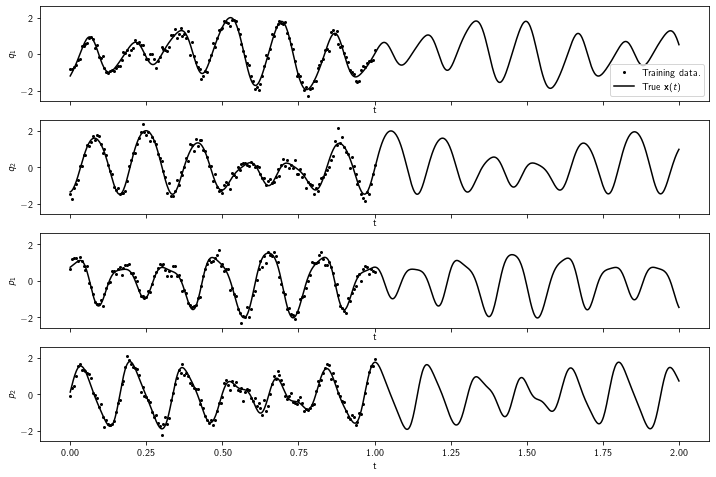

In [4]:
fig, axs = plt.subplots(system.trn.ys.shape[-1], 1, figsize=(12, 8), sharex=True, sharey=True)
coord_labels = ["$q_1$", "$q_2$", "$p_1$", "$p_2$"]
for i in range(system.trn.ys.shape[-1]):
    axs[i].scatter(system.trn.ts, system.trn.ys[0, :, i], s=4, c="k", label="Training data.")
    axs[i].plot(system.tst.ts, system.tst.ys[0, :, i], c="k", label="True $\mathbf{x}(t)$")
    axs[i].set_ylabel(coord_labels[i])
    axs[i].set_xlabel("t")
axs[0].legend()

Next we'll build a HGP, using the energy conserving shooting approach discussed in the paper, and fit the data.

In [5]:
model_config = DotMap(
    {
        "solver": "dopri5", # ODE solver method
        "use_adjoint": False, # Use adjoint for solver backprop

        "eval_samples": 16, # Number of samples to use for model predictions
        "init_noise": 0.1, # Initial value of the noise variance 
        "num_iter": 1000, # number of training iterations
        "lr": 3e-3, # learning rate 
        "log_freq": 100, # logging freqency in training
        "model": {
            "inducing_init": True, # use Hamiltonian aware intialisation
            "num_features": 256, # Number of RFF features for prior 
            "num_inducing": 48, # Number of inducing points 
            "q_diag": False, # Diagonal approximation of inducing variational distribution.
            "shooting": True, # Use shooting 
            "constraint_type": "gauss", # Likelihood type for shooting constriant
            "constraint_trainable": False, # Is shooting constraint trainable 
            "constraint_initial_scale": 1e-3, #Value of shooting constraint
            "constrain_energy": True, # Use energy constrained shooting 
            "energy_constraint_initial_scale": 5e-2, #Value of energy shooting constraint
            "shooting_time_factor": 4, #Use 1 shooting state per 4 datapoints 
            # Factor to make integration points more dense, in this case 4 times as many integration
            # points are used than data points
            "ts_dense_scale": 4,
        },
    }
)

model = hgp.models.builder.build_model(model_config, system.trn.ys)


Fitting model...
Iter 0100 | Loss 1014.73(4728.91) |OBS NLL 0.06(0.14) | XS KL 714.60(3782.59) | E KL 55.66(702.04) |X0 KL 0.04(0.04) | IND KL 243.50(243.30)
Iter 0200 | Loss 342.34(1018.43) |OBS NLL 0.01(0.03) | XS KL 85.12(664.64) | E KL 12.58(109.22) |X0 KL 0.04(0.04) | IND KL 243.56(243.53)
Iter 0300 | Loss 272.51(384.18) |OBS NLL -0.00(0.00) | XS KL 23.82(120.27) | E KL 4.15(19.33) |X0 KL 0.04(0.04) | IND KL 243.43(243.49)
Iter 0400 | Loss 258.13(277.74) |OBS NLL -0.01(-0.01) | XS KL 10.37(27.74) | E KL 3.42(5.57) |X0 KL 0.04(0.04) | IND KL 243.23(243.32)
Iter 0500 | Loss 251.62(257.22) |OBS NLL -0.01(-0.01) | XS KL 5.18(9.91) | E KL 2.34(3.10) |X0 KL 0.04(0.04) | IND KL 243.00(243.11)
Iter 0600 | Loss 249.99(252.27) |OBS NLL -0.01(-0.01) | XS KL 4.07(5.76) | E KL 2.07(2.53) |X0 KL 0.04(0.04) | IND KL 242.74(242.87)
Iter 0700 | Loss 249.19(250.18) |OBS NLL -0.01(-0.01) | XS KL 3.68(4.26) | E KL 1.94(2.22) |X0 KL 0.05(0.04) | IND KL 242.46(242.60)
Iter 0800 | Loss 249.11(249.42) |O

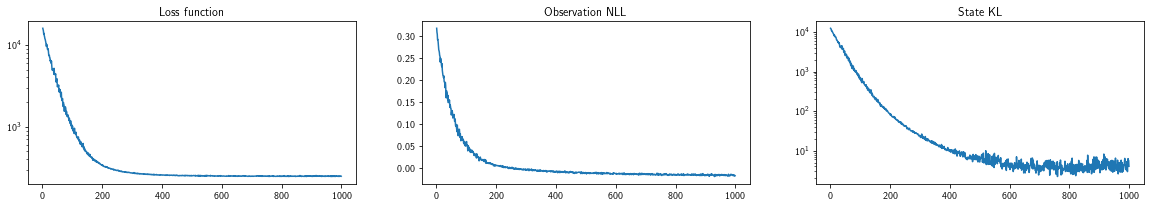

In [6]:
model, history = hgp.models.builder.init_and_fit(
    model, model_config, system.trn.ts, system.trn.ys, return_history=True
)
plot_learning_curve(history)

Now let's make some predictions using the model, and plot them.

In [7]:
preds = hgp.models.builder.compute_predictions(
        model,
        numpy2torch(system.tst.ts),
        eval_sample_size=model_config.eval_samples,
    )

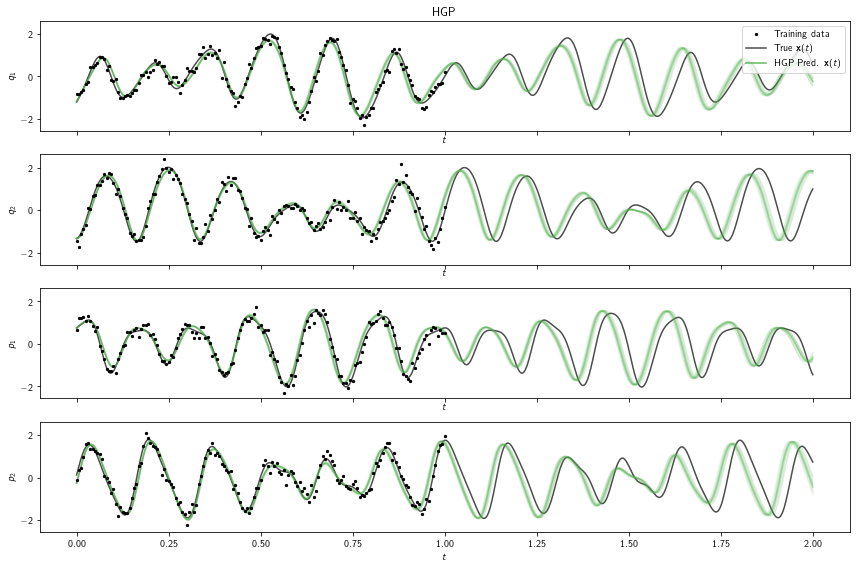

In [8]:
_ = plot_predictions(
    system,
    preds, model_name="HGP")

In the plot above, each green line is a sample from the model, We can see tha the model is able to extrapolate forward in time reasonably accurately, with uncertainty. 